In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class ForecastNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForecastNN, self).__init__()
        self.K1 = nn.Linear(input_size, hidden_size, bias=False)
        self.K2 = nn.Linear(hidden_size, output_size, bias=False)
        self.hidden_activation = nn.ReLU()  # f_hidden function
        self.output_activation = nn.Tanh()  # f_out function
    
    def forward(self, x):
        # Суммирование входов с весами
        weighted_input = self.K1(x)
        
        # Применение скрытой функции активации
        hidden_output = self.hidden_activation(weighted_input)
        
        # Взвешивание скрытых слоев и выход
        weighted_hidden_output = self.K2(hidden_output)
        
        # Применение выходной функции активации
        output = self.output_activation(weighted_hidden_output)
        
        return output


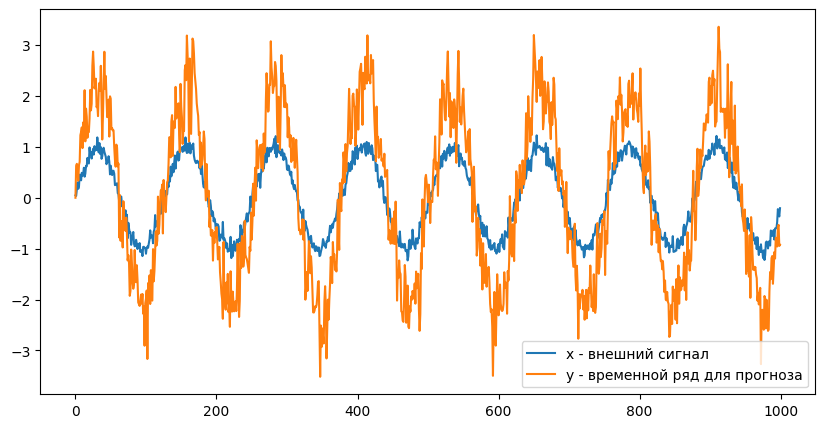

In [3]:
np.random.seed(42)
torch.manual_seed(42)

n = 1000
x = np.sin(np.linspace(0, 50, n)) + np.random.normal(0, 0.1, n)
y = np.zeros(n)

for t in range(1, n):
    y[t] = 0.4 * y[t-1] + 1.3 * x[t-1] + np.random.normal(0, 0.4)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(x, label='x - внешний сигнал')
plt.plot(y, label='y - временной ряд для прогноза')
plt.legend()
plt.show()


In [4]:
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)
y = y.to(device)

train_size = int(n * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [5]:
input_size = 1
hidden_size = 50
output_size = 1

model = ForecastNN(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


c:\Users\waclo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 630.1764526367188
Epoch 10, Loss: 114.83915710449219
Epoch 20, Loss: 111.54608154296875
Epoch 30, Loss: 113.88933563232422
Epoch 40, Loss: 113.65281677246094


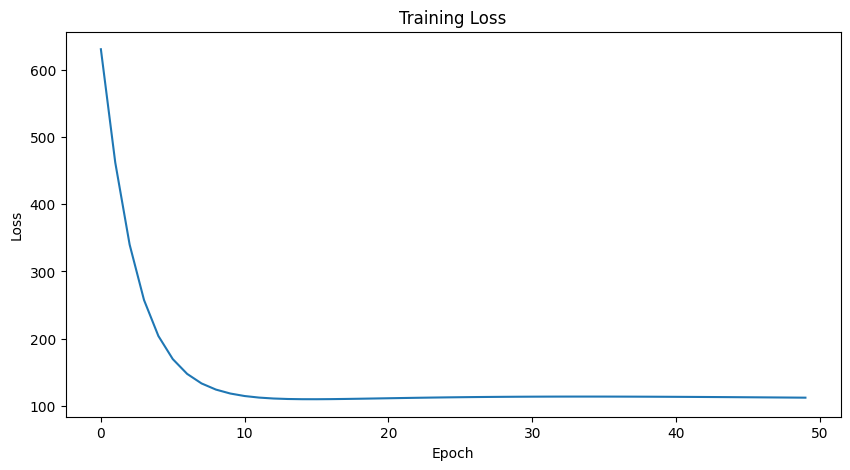

In [6]:
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    loss = 0
    
    for t in range(1, train_size):
        x_t = x_train[t].unsqueeze(0).to(device)
        y_t = y_train[t].to(device)
        
        y_pred = model(x_t)
        loss += criterion(y_pred, y_t)
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


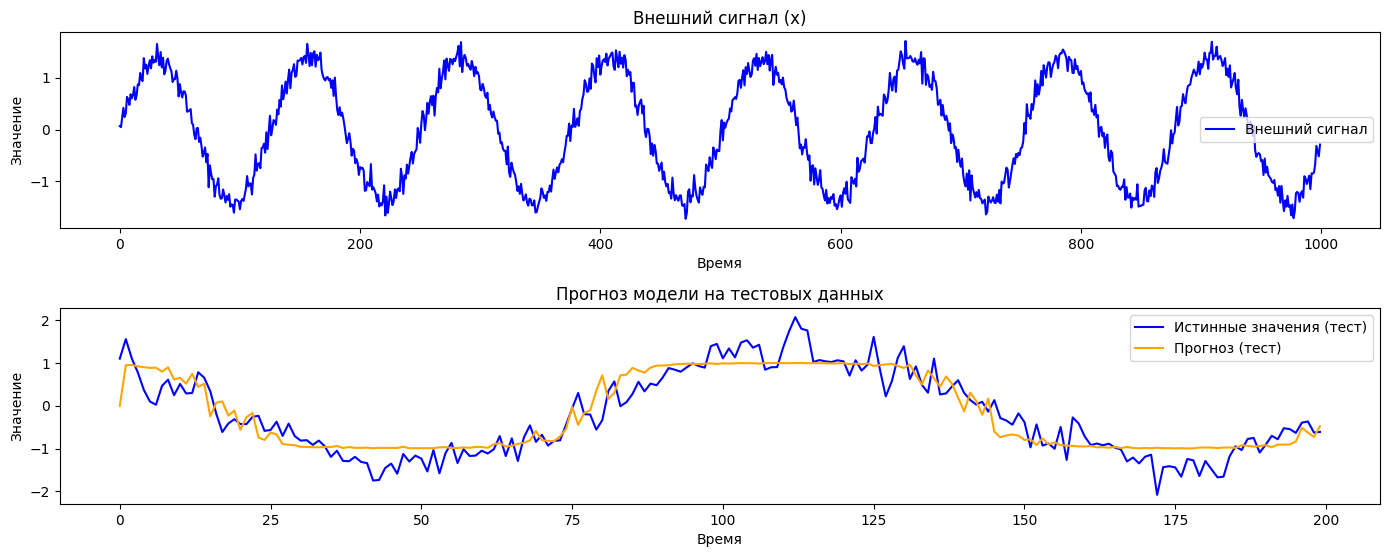

In [7]:
model.eval()
y_test_pred = torch.zeros_like(y_test, device=device)

with torch.no_grad():
    for t in range(1, len(y_test)):
        x_t = x_test[t].unsqueeze(0).to(device)
        y_test_pred[t] = model(x_t)

# Перенос данных обратно на CPU для визуализации
y_test_pred = y_test_pred.cpu()
y_test = y_test.cpu()
x = x.cpu()


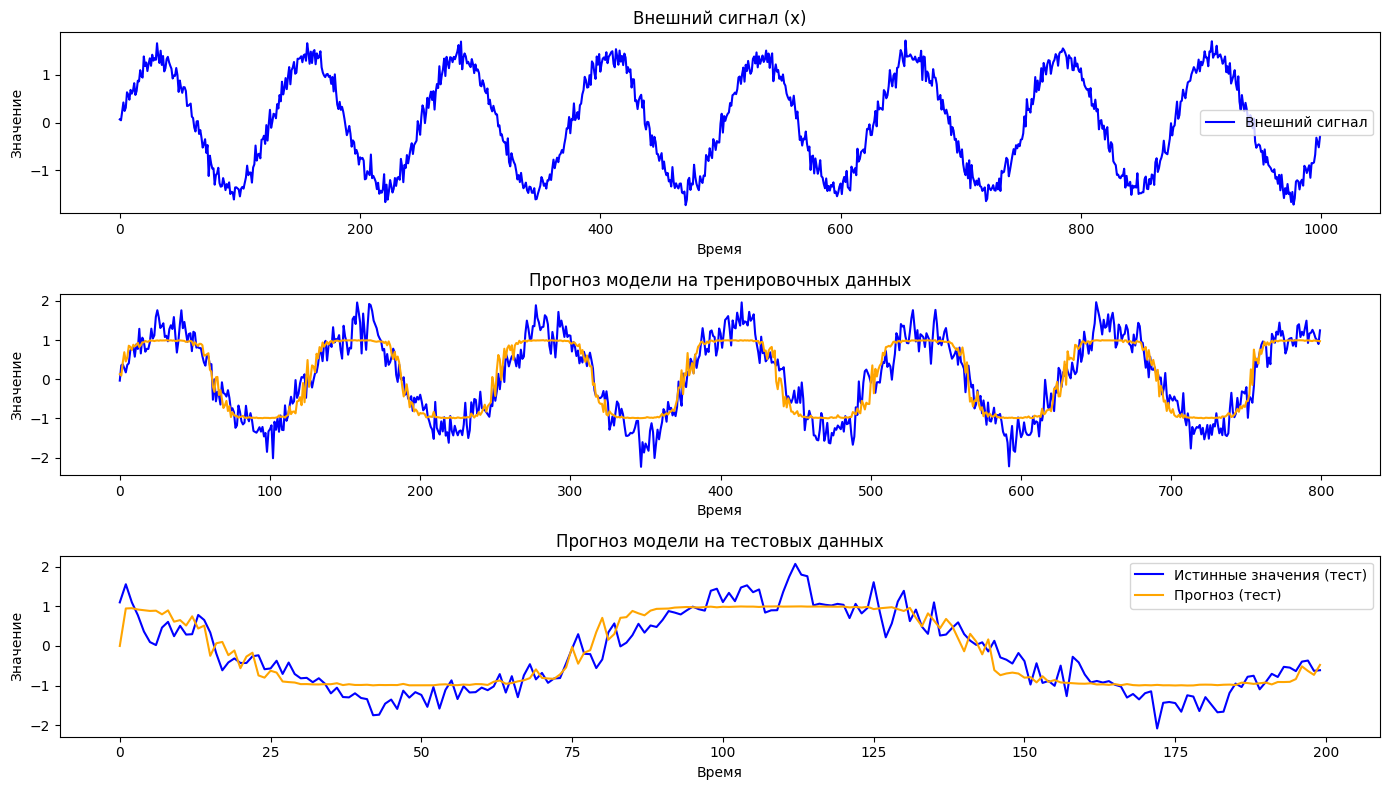

In [10]:

plt.figure(figsize=(14, 8))

# График внешнего сигнала x
plt.subplot(3, 1, 1)
plt.plot(x.detach().numpy(), label='Внешний сигнал', color='blue')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Внешний сигнал (x)')
plt.legend()

# График тренировочной выборки
plt.subplot(3, 1, 2)
plt.plot(y_train.cpu().detach().numpy(), label='Истинные значения (тренировка)', color='blue')
plt.plot(range(len(y_train)), model(x_train).cpu().detach().numpy(), label='Прогноз (тренировка)', color='orange')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Прогноз модели на тренировочных данных')

# График тестовой выборки
plt.subplot(3, 1, 3)
plt.plot(y_test.detach().numpy(), label='Истинные значения (тест)', color='blue')
plt.plot(range(len(y_test)), y_test_pred.detach().numpy(), label='Прогноз (тест)', color='orange')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Прогноз модели на тестовых данных')
plt.legend()


plt.tight_layout()
plt.show()
